In [1]:
import sys
sys.path.insert(1, '..')
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sqlalchemy import create_engine

from snorkel.labeling import labeling_function

## Load Data

### DataFrame

In [2]:
## load the data by choosing a random 10% of the data
## is the data ordered? am I missing a large chunk due to my partial loading?
# p = 0.01
# responses = pd.read_csv('../data/moralmachine/SharedResponses.csv', skiprows=lambda i: i>0 and random.random() > p)

### SQL Engine

In [3]:
# access SQL DB with data
engine = create_engine("sqlite:///../data/moralmachine.db", echo=False)

In [4]:
# demo
# responses = pd.read_sql("SELECT * FROM sharedresponses ORDER BY RANDOM() LIMIT 100000", con=engine)
# responses.columns

In [5]:
# ## For viewing the possible values for each feature
# for feature in responses.columns:
#     print(feature)
#     print(responses[feature].unique())
#     print(responses[feature].unique().shape)

In [6]:
# ## What does a single user's session/response look like?
# responses_random = responses[responses['ScenarioTypeStrict'] == 'Random']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     ## see a random user's session
# #     display(responses_random[responses_random['ExtendedSessionID'] == responses_random['ExtendedSessionID'].sample().values[0]])
    
#     ## see the user with nth most responses
#     n = 100
#     display(responses_random[responses_random['ResponseID'] == responses_random.groupby(by='ResponseID').size().sort_values(ascending=False).index[n]]) 

In [7]:
# ## group alternatives pairwise!
# # take only responses where both alternatives are present in the random sample - for a full sample, this step isn't necessary
# responses_grouped = responses.groupby(by='ResponseID').filter(lambda g: g.shape[0] < 2)
# responses_grouped.shape

## Data Exploration

In [8]:
# responses.describe()

## Snorkel Labeling
Using https://www.snorkel.org/use-cases/01-spam-tutorial

### Sample Data

In [9]:
# query random sample of responses grouped by ResponseID; only take responses for which both instances are present
sample_size = 1000000
query = """
    SELECT gc.session_count, sr.* FROM sharedresponses sr
    INNER JOIN (
        SELECT ExtendedSessionID, COUNT(DISTINCT ResponseID) AS session_count FROM sharedresponses
        WHERE UserID <> ''
        
        /* Get only full sessions. */
        GROUP BY ExtendedSessionID
            HAVING COUNT(DISTINCT ResponseID) LIKE 13
                AND COUNT(ResponseID) LIKE 26
        
        LIMIT {0:d}
    ) gc
        ON gc.ExtendedSessionID = sr.ExtendedSessionID
    ORDER BY sr.UserID
""".format(sample_size)
df = pd.read_sql(query, con=engine)
df

,session_count,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
0,13,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,9,0,0,1,0,Fat,...,0,0,0,0,0,0,0,0,0,0
1,13,CDnbR339euts3x3c3,1295349308_1000284909295010.0,1000284909295010,6,0,1,0,0,Less,...,0,0,0,0,0,0,1,0,0,0
2,13,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,0,0,1,0,Rand,...,1,0,0,1,0,0,0,0,0,0
3,13,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,5,0,1,0,0,Young,...,0,0,0,0,0,0,0,0,0,0
4,13,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,9,1,0,0,0,Fit,...,0,0,0,0,1,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544915,13,oNwjkhRzJpiBHfJNB,1708630306_9999973699194224.0,9999973699194220,4,0,1,0,0,Fit,...,0,0,0,0,1,1,0,0,0,0
1544916,13,zjbT9ydvthWaApyz3,1708630306_9999973699194224.0,9999973699194220,12,0,0,1,0,Old,...,0,0,0,0,0,0,0,0,0,0
1544917,13,nhxSBhkYqDjNqqeYu,1708630306_9999973699194224.0,9999973699194220,3,1,1,0,0,High,...,0,0,0,0,0,0,0,0,0,0
1544918,13,oNwjkhRzJpiBHfJNB,1708630306_9999973699194224.0,9999973699194220,4,1,1,0,0,Fat,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# size and other stuff
df.describe()

,session_count,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
count,1544920.0,1.544920e+06,1544920.0,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1544920.0,1.544920e+06,...,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06,1.544920e+06
mean,13.0,6.995973e+00,0.5,4.525270e-01,2.737365e-01,6.062489e-01,2.901300e+00,5.101623e-01,0.5,3.132848e-01,...,1.441291e-01,5.329079e-02,1.073615e-01,1.071712e-01,1.731565e-01,1.724141e-01,9.103190e-02,9.081765e-02,1.561356e-01,1.564081e-01
std,0.0,3.742443e+00,0.5,4.977414e-01,4.458755e-01,8.149253e-01,1.492986e+00,1.099643e+00,0.5,5.904199e-01,...,4.278764e-01,2.423233e-01,3.480164e-01,3.474571e-01,5.008922e-01,4.997909e-01,3.227842e-01,3.221732e-01,5.405188e-01,5.417887e-01
min,13.0,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,13.0,4.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,13.0,7.000000e+00,0.5,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.5,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,13.0,1.000000e+01,1.0,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,1.0,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,13.0,1.300000e+01,1.0,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,4.000000e+00,1.0,5.000000e+00,...,5.000000e+00,4.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


In [11]:
# number of users
df['UserID'].nunique()

51211

For comparison to Noothigattu et al., how many pairwise comparisons per voter in this sample dataset?

In [12]:
# number of pairwise comparisons per voter?
# = number of response IDs per voter
df.groupby('UserID')['ResponseID'].nunique().mean()

15.083868700083967

In [13]:
# number of scenarios
pd.DataFrame(df['ScenarioType'].value_counts()/df['ScenarioType'].value_counts().sum()).to_csv("../figures/data/freq_scenario.csv")
# frequency of each character count
characters = ['Man', 'Woman', 'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog', 'Cat']
pd.DataFrame(df[characters].sum()/df[characters].sum().sum(), columns=['frequency']).to_csv('../figures/data/freq_character.csv')

In [14]:
# user countries
freqs = df['UserCountry3'].value_counts()
pd.DataFrame(freqs/freqs.sum()).to_csv('../figures/data/freq_countries.csv')

In [15]:
df.iloc[:26,:].sort_values('ScenarioOrder')

,session_count,ResponseID,ExtendedSessionID,UserID,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
12,13,P3nEs8eAZDgegGQgL,1295349308_1000284909295010.0,1000284909295010,1,1,1,0,1,Low,...,0,0,0,0,0,0,0,0,0,0
9,13,P3nEs8eAZDgegGQgL,1295349308_1000284909295010.0,1000284909295010,1,0,1,0,2,High,...,0,0,0,0,0,0,0,0,0,0
2,13,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,0,0,1,0,Rand,...,1,0,0,1,0,0,0,0,0,0
6,13,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,1,0,0,1,Rand,...,0,1,0,1,0,0,0,0,0,0
17,13,mYhYL5Gxwpg53whqt,1295349308_1000284909295010.0,1000284909295010,3,1,0,0,0,Female,...,0,0,0,0,0,0,0,0,0,0
15,13,mYhYL5Gxwpg53whqt,1295349308_1000284909295010.0,1000284909295010,3,0,0,1,0,Male,...,1,0,0,0,0,0,0,0,0,0
22,13,rqrbkEMFStk5znStw,1295349308_1000284909295010.0,1000284909295010,4,1,0,1,0,Rand,...,0,0,0,0,0,0,0,0,0,0
18,13,rqrbkEMFStk5znStw,1295349308_1000284909295010.0,1000284909295010,4,0,0,0,0,Rand,...,0,0,0,0,0,1,0,0,0,0
3,13,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,5,0,1,0,0,Young,...,0,0,0,0,0,0,0,0,0,0
7,13,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,5,1,1,0,0,Old,...,0,0,0,0,0,0,0,0,0,0


Out of the variables above, these are the variables that vary within response pairs:
> 'NumberOfCharacters', 'DiffNumberOfCharacters', 'Saved', 'Template', 'DescriptionShown',
'LeftHand', 'UserCountry3', 'Man', 'Woman', 'Pregnant', 'Stroller',
'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless', 'LargeWoman',
'LargeMan', 'Criminal', 'MaleExecutive', 'FemaleExecutive',
'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor', 'MaleDoctor', 'Dog',
'Cat'

N.B. in each pair of responses, only one is the result of an intervention, and only one is saved. 

In [16]:
df[["ResponseID","Intervention","Saved"]].head()

,ResponseID,Intervention,Saved
0,C4yoxBdFMTE3tAjEu,0,1
1,CDnbR339euts3x3c3,0,0
2,CMChvaNp5QZup4QBw,0,1
3,CZ3BfpjubdHMdqq6z,0,1
4,C4yoxBdFMTE3tAjEu,1,0


### Preprocessing

First, let's convert to abstract features for ease of labeling.

In [17]:
import hmm.labeling.utils
importlib.reload(hmm.labeling.utils)
from hmm.labeling.utils import transform_abstract

ids = ['ResponseID', 'ExtendedSessionID', 'UserID']
df_i = df.set_index(ids, append=True, verify_integrity=True)
df_i.index = df_i.index.set_names(['UUID']+ids)
df_abstract = transform_abstract(df_i)
df_abstract.head()

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
0,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,13,9,0,1,0,Fat,Fitness,Fitness,Fit,Fat,...,0,0,0,0,0,3,0,1,1,1
1,CDnbR339euts3x3c3,1295349308_1000284909295010.0,1000284909295010,13,6,1,0,0,Less,Utilitarian,Utilitarian,More,Less,...,0,0,1,0,0,2,0,0,0,1
2,CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,13,2,0,1,0,Rand,Random,Random,,,...,0,1,0,0,0,5,0,1,1,1
3,CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,13,5,1,0,0,Young,Age,Age,Young,Old,...,0,0,0,0,0,4,0,0,0,1
4,C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,13,9,0,0,0,Fit,Fitness,Fitness,Fit,Fat,...,3,0,0,0,0,3,0,0,0,1


Now let's check our work.

In [18]:
sample = df_i.sample().index
df_i.loc[sample]

,,,,session_count,ScenarioOrder,Intervention,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,...,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
893270,bwGSyDswrT4Bzvo49,-1208126312_447671532165259.0,447671532165259,13,3,0,1,0,2,Pets,Species,Species,Hoomans,...,0,0,0,0,0,1,2,False,False,False


In [19]:
df_abstract.loc[sample]

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
UUID,ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
893270,bwGSyDswrT4Bzvo49,-1208126312_447671532165259.0,447671532165259,13,3,1,0,2,Pets,Species,Species,Hoomans,Pets,...,0,0,0,0,0,0,3,0,0,0


In [20]:
df_abstract.columns

Index(['session_count', 'ScenarioOrder', 'PedPed', 'Barrier', 'CrossingSignal',
       'AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'NumberOfCharacters',
       'DiffNumberOFCharacters', 'Saved', 'Template', 'DescriptionShown',
       'LeftHand', 'UserCountry3', 'Intervene', 'Male', 'Female', 'Young',
       'Old', 'Infancy', 'Pregnancy', 'Fat', 'Fit', 'Working', 'Medical',
       'Homeless', 'Criminal', 'Human', 'Non-human', 'Passenger',
       'Law Abiding', 'Law Violating'],
      dtype='object')

First, select the fields that are unique to each scenario (the fields that vary within pairs of responses). Then split the dataset into two disjoint sets of alternatives: one in which an intervention occurs, and one in which there is no intervention.

In [21]:
ids = ["ResponseID", "ExtendedSessionID", "UserID"]
scenario_fields = [
    'Saved', 'NumberOfCharacters', 'DescriptionShown', 'LeftHand', 'Male', 'Female', 'Young', 'Old', 'Infancy', 'Pregnancy',
    'Fat', 'Fit', 'Working', 'Medical', 'Homeless', 'Criminal', 'Human',
    'Non-human', 'Passenger', 'Law Abiding', 'Law Violating'
]

df_abstract = df_abstract.reset_index(level='UUID')
sample_response = df_abstract.sample().index
intervention = df_abstract[df_abstract['Intervene'] == 1][scenario_fields]
no_intervention = df_abstract[df_abstract['Intervene'] == 0][scenario_fields]

print("Alternative w/ intervention:")
display(intervention.loc[sample_response])
print("Alternative w/o intervention:")
display(no_intervention.loc[sample_response])

Alternative w/ intervention:


,,,Saved,NumberOfCharacters,DescriptionShown,LeftHand,Male,Female,Young,Old,Infancy,Pregnancy,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
K2BAr4xHEaQK2oc7A,922074117_3179502013.0,3179502013,1,5,1,0,1,1,1,0,1,0,...,1,0,0,0,2,5,0,0,0,1


Alternative w/o intervention:


,,,Saved,NumberOfCharacters,DescriptionShown,LeftHand,Male,Female,Young,Old,Infancy,Pregnancy,...,Fit,Working,Medical,Homeless,Criminal,Human,Non-human,Passenger,Law Abiding,Law Violating
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
K2BAr4xHEaQK2oc7A,922074117_3179502013.0,3179502013,0,3,1,1,0,1,1,0,1,0,...,0,0,0,0,1,3,0,1,1,1


Next, combine the datasets on response ID, separating the variable characteristics with suffixes.

In [22]:
df_endo = intervention.join(no_intervention, lsuffix='_int', rsuffix='_noint', how='inner')
df_endo.loc[sample_response]

,,,Saved_int,NumberOfCharacters_int,DescriptionShown_int,LeftHand_int,Male_int,Female_int,Young_int,Old_int,Infancy_int,Pregnancy_int,...,Fit_noint,Working_noint,Medical_noint,Homeless_noint,Criminal_noint,Human_noint,Non-human_noint,Passenger_noint,Law Abiding_noint,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,,,,,,
K2BAr4xHEaQK2oc7A,922074117_3179502013.0,3179502013,1,5,1,0,1,1,1,0,1,0,...,0,0,0,0,1,3,0,1,1,1


Get data for the columns from the raw data that _didn't_ change within response pairs. Remember to eliminate duplicate response pairs - now that we have a combined tuple for each pairwise comparison, they're no longer necessary.

In [23]:
df_exo = df_abstract[[col for col in df_abstract.columns if col not in scenario_fields]]
df_exo = df_exo.loc[~df_exo.index.duplicated(keep='first')]
df_exo.loc[sample_response]

,,,UUID,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,DefaultChoiceIsOmission,DiffNumberOFCharacters,Template,UserCountry3,Intervene
ResponseID,ExtendedSessionID,UserID,,,,,,,,,,,,,,,,
K2BAr4xHEaQK2oc7A,922074117_3179502013.0,3179502013,584656,13,8,0,1,0,Less,Utilitarian,Utilitarian,More,Less,0,2,Desktop,USA,0


Then join that data in with the combined endogenous variables to get a full tuple for each pairwise comparison presented to a user.

In [24]:
df_joined = df_exo.join(df_endo, how='inner').set_index(['UUID'], append=True, verify_integrity=True)
sample = df_joined.sample().index
df_joined.loc[sample]

,,,,session_count,ScenarioOrder,PedPed,Barrier,CrossingSignal,AttributeLevel,ScenarioTypeStrict,ScenarioType,DefaultChoice,NonDefaultChoice,...,Fit_noint,Working_noint,Medical_noint,Homeless_noint,Criminal_noint,Human_noint,Non-human_noint,Passenger_noint,Law Abiding_noint,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
iQmREL4RALMM9Q6hQ,-1994649228_6434374093078077.0,6434374093078080,1126963,13,10,0,1,0,Less,Utilitarian,Utilitarian,More,Less,...,0,0,0,2,0,3,0,1,1,1


In [25]:
import hmm.labeling.utils
importlib.reload(hmm.labeling.utils)
from hmm.labeling.utils import pictofy
    
# works with abstract
pictofy(df_joined.loc[sample])

What should the self-driving car do? (ScenarioType: Utilitarian)

	    🚘 
	   |	\ 
	   v 	 v
	🔴🚧 	🚸 
	 NOINT	INT	
INT saves: 
['2 Male', '1 Female', '1 Old', '1 Working', '2 Homeless', '5 Human']
NOINT saves: 
['1 Male', '1 Old', '2 Homeless', '3 Human']



How much data did we lose with all these joins? Shouldn't be any - all we're doing is dividing the dataset in half.

In [26]:
print("df: {}".format(df.shape))
print("df_endo: {}".format(df_endo.shape))
print("df_exo: {}".format(df_exo.shape))
print("df_joined: {}".format(df_joined.shape))

df: (1544920, 42)
df_endo: (772460, 42)
df_exo: (772460, 16)
df_joined: (772460, 57)


Finally, let's make it easier to interpret the target variable. For each response, we know whether the user chose to save one set of characters (\_int) by intervention, or save another set (\_noint) by not intervening. Let's call that variable "Intervened" to indicate whether or not the user intervened (swerved the AV).

In [27]:
df_joined['Intervened'] = (df_joined['Saved_int'] == 1).astype(int)
df_joined = df_joined.drop(axis='columns', labels=['Saved_{}'.format(s) for s in ['int', 'noint']]+["Intervene"])
scenario_fields.remove('Saved')
df_joined.columns

Index(['session_count', 'ScenarioOrder', 'PedPed', 'Barrier', 'CrossingSignal',
       'AttributeLevel', 'ScenarioTypeStrict', 'ScenarioType', 'DefaultChoice',
       'NonDefaultChoice', 'DefaultChoiceIsOmission', 'DiffNumberOFCharacters',
       'Template', 'UserCountry3', 'NumberOfCharacters_int',
       'DescriptionShown_int', 'LeftHand_int', 'Male_int', 'Female_int',
       'Young_int', 'Old_int', 'Infancy_int', 'Pregnancy_int', 'Fat_int',
       'Fit_int', 'Working_int', 'Medical_int', 'Homeless_int', 'Criminal_int',
       'Human_int', 'Non-human_int', 'Passenger_int', 'Law Abiding_int',
       'Law Violating_int', 'NumberOfCharacters_noint',
       'DescriptionShown_noint', 'LeftHand_noint', 'Male_noint',
       'Female_noint', 'Young_noint', 'Old_noint', 'Infancy_noint',
       'Pregnancy_noint', 'Fat_noint', 'Fit_noint', 'Working_noint',
       'Medical_noint', 'Homeless_noint', 'Criminal_noint', 'Human_noint',
       'Non-human_noint', 'Passenger_noint', 'Law Abiding_noint',


Now choose which features to use:

In [28]:
# include user countries and other metadata or not? decided not - experts writing LFs are trying to decide most moral response, not predict what an individual from a certain background would do
# but if it helps generalization, technically useful... try both?
target = ["Intervened"]
features = ["Template", "UserCountry3"] + ["{}_{}".format(f, s) for f in scenario_fields for s in ["int", "noint"]]
cat_features = [
    "Template", "UserCountry3"
]
num_features = [f for f in features if f not in cat_features]
df_joined[features].head()

,,,,Template,UserCountry3,NumberOfCharacters_int,NumberOfCharacters_noint,DescriptionShown_int,DescriptionShown_noint,LeftHand_int,LeftHand_noint,Male_int,Male_noint,...,Human_int,Human_noint,Non-human_int,Non-human_noint,Passenger_int,Passenger_noint,Law Abiding_int,Law Abiding_noint,Law Violating_int,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
C4yoxBdFMTE3tAjEu,1295349308_1000284909295010.0,1000284909295010,0,Desktop,MEX,3,3,0,0,1,0,2,2,...,3,3,0,0,0,1,0,1,1,1
CDnbR339euts3x3c3,1295349308_1000284909295010.0,1000284909295010,1,Desktop,MEX,5,2,0,0,1,0,1,0,...,4,2,1,0,0,0,0,0,1,1
CMChvaNp5QZup4QBw,1295349308_1000284909295010.0,1000284909295010,2,Desktop,MEX,5,5,0,0,1,0,1,2,...,5,5,0,0,0,1,1,1,0,1
CZ3BfpjubdHMdqq6z,1295349308_1000284909295010.0,1000284909295010,3,Desktop,MEX,4,4,0,0,1,0,0,0,...,4,4,0,0,0,0,0,0,1,1
Kvr4yzcYB8QAxykMg,1295349308_1000284909295010.0,1000284909295010,8,Desktop,MEX,2,2,0,0,1,0,2,0,...,2,2,0,0,0,0,0,0,1,1


Now explicitly type cast and deal with NA's or missing values:

In [29]:
# transform numerical data types
df_proc = df_joined.loc[:, features + target]

def transform_num(df, num_features):
    # convert to numeric, changing literals to NaN
    for f in num_features:
        df.loc[:, f] = pd.to_numeric(df.loc[:, f], errors='coerce')
    # are there any nan in the numerical features? usually just one
    nan = df[df[num_features].isna().any(axis=1)]
    print("Dropping these NaN:")
    display(nan)
    return df.dropna(axis=0, how='any', subset=num_features)

df_proc = transform_num(df_proc, num_features)
df_proc.columns

/opt/miniconda3/envs/hmm/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Dropping these NaN:


,,,,Template,UserCountry3,NumberOfCharacters_int,NumberOfCharacters_noint,DescriptionShown_int,DescriptionShown_noint,LeftHand_int,LeftHand_noint,Male_int,Male_noint,...,Human_noint,Non-human_int,Non-human_noint,Passenger_int,Passenger_noint,Law Abiding_int,Law Abiding_noint,Law Violating_int,Law Violating_noint,Intervened
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
9XqeeDRQxdjXGtysP,-1132097515_1001529134,1001529134,182,,ROU,1,5,NaN,NaN,NaN,NaN,0,3,...,5,0,0,0,1,0,1,1,1,0
KQCdXCp4BcnqmmEky,-1132097515_1001529134,1001529134,184,,ROU,2,2,NaN,NaN,NaN,NaN,1,1,...,2,0,0,1,0,1,0,1,0,1
Ljhao6hyR8PAtMEP4,-1132097515_1001529134,1001529134,185,,ROU,2,2,NaN,NaN,NaN,NaN,0,2,...,2,0,0,1,0,1,0,1,0,1
MB9o7ub7KkvdWaD6j,-1132097515_1001529134,1001529134,186,,ROU,3,3,NaN,NaN,NaN,NaN,3,0,...,3,0,0,1,0,1,0,1,0,1
PRPQctv4Jzbxo7pMM,-1132097515_1001529134,1001529134,187,,ROU,1,1,NaN,NaN,NaN,NaN,1,1,...,1,0,0,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
o2i62HYZFCaiLSAeD,970197532_997534616,997534616,1541867,,MEX,1,1,NaN,NaN,NaN,NaN,1,1,...,1,0,0,1,0,1,1,1,0,1
pPGge5qxnWErpnWSs,970197532_997534616,997534616,1541868,,MEX,5,3,NaN,NaN,NaN,NaN,2,1,...,3,0,0,0,0,0,0,1,1,1
rccbnRp8ht7kyyXux,970197532_997534616,997534616,1541869,,MEX,2,2,NaN,NaN,NaN,NaN,0,0,...,2,2,0,1,0,1,0,1,0,1


Index(['Template', 'UserCountry3', 'NumberOfCharacters_int',
       'NumberOfCharacters_noint', 'DescriptionShown_int',
       'DescriptionShown_noint', 'LeftHand_int', 'LeftHand_noint', 'Male_int',
       'Male_noint', 'Female_int', 'Female_noint', 'Young_int', 'Young_noint',
       'Old_int', 'Old_noint', 'Infancy_int', 'Infancy_noint', 'Pregnancy_int',
       'Pregnancy_noint', 'Fat_int', 'Fat_noint', 'Fit_int', 'Fit_noint',
       'Working_int', 'Working_noint', 'Medical_int', 'Medical_noint',
       'Homeless_int', 'Homeless_noint', 'Criminal_int', 'Criminal_noint',
       'Human_int', 'Human_noint', 'Non-human_int', 'Non-human_noint',
       'Passenger_int', 'Passenger_noint', 'Law Abiding_int',
       'Law Abiding_noint', 'Law Violating_int', 'Law Violating_noint',
       'Intervened'],
      dtype='object')

### Train/Test Split

A standard train test split for testing:

In [88]:
import hmm.classification
importlib.reload(hmm.classification)
from hmm.classification import train_test_val_dev_split

def make_X_y(df):
    X = df.drop(labels=["Intervened"], axis='columns', inplace=False)
    y = df["Intervened"]
    return X, y

X, y = make_X_y(df_proc)
X_train, X_test, X_val, X_dev, y_train, y_test, y_val, y_dev = train_test_val_dev_split(X, y)
display(X_train.head())
display(y_train.head())
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(X_dev.shape)

,,,,Template,UserCountry3,NumberOfCharacters_int,NumberOfCharacters_noint,DescriptionShown_int,DescriptionShown_noint,LeftHand_int,LeftHand_noint,Male_int,Male_noint,...,Human_int,Human_noint,Non-human_int,Non-human_noint,Passenger_int,Passenger_noint,Law Abiding_int,Law Abiding_noint,Law Violating_int,Law Violating_noint
ResponseID,ExtendedSessionID,UserID,UUID,,,,,,,,,,,,,,,,,,,,,
zMxxfgF5toKascmBC,-1560484671_5278886028275740.0,5278886028275740,990986,Mobile,DZA,2,2,0.0,0.0,1.0,0.0,0,0,...,2,2,0,0,0,0,1,0,0,0
JKxFztgS4cZc6iGx6,694893935_9451969873639508.0,9451969873639510,1482082,Desktop,NOR,5,5,0.0,0.0,1.0,0.0,2,2,...,5,5,0,0,0,0,1,0,0,0
ZnvDbZjQS24j6rXtg,-688785863_4707035014871508.0,4707035014871510,920524,Mobile,JPN,1,1,1.0,1.0,0.0,1.0,1,0,...,1,0,0,1,0,0,0,1,0,0
nbFBW7od8dNXobhCE,1228232883_2636069680125507.0,2636069680125510,434636,Desktop,AUS,5,4,0.0,0.0,0.0,1.0,3,1,...,3,4,2,0,1,0,1,1,1,0
w9F5iLSRTWPPRwxTK,-2023517918_2912710996256167.0,2912710996256170,511256,Mobile,BRA,2,2,0.0,0.0,1.0,0.0,1,0,...,2,2,0,0,1,0,1,0,1,0


ResponseID         ExtendedSessionID               UserID            UUID   
zMxxfgF5toKascmBC  -1560484671_5278886028275740.0  5278886028275740  990986     0
JKxFztgS4cZc6iGx6  694893935_9451969873639508.0    9451969873639510  1482082    1
ZnvDbZjQS24j6rXtg  -688785863_4707035014871508.0   4707035014871510  920524     1
nbFBW7od8dNXobhCE  1228232883_2636069680125507.0   2636069680125510  434636     1
w9F5iLSRTWPPRwxTK  -2023517918_2912710996256167.0  2912710996256170  511256     0
Name: Intervened, dtype: int64

(424419, 42)
(106105, 42)
(106105, 42)
(26527, 42)


### Labeling Model

Some sample labeling functions, constructed with the help of the effect sizes in the Moral Machine experiment.

In [31]:
import hmm.labeling.moralmachine as mm
import hmm.labeling.models
import hmm.labeling.utils
importlib.reload(hmm.labeling.moralmachine)
importlib.reload(hmm.labeling.models)
importlib.reload(hmm.labeling.utils)
import hmm.labeling.moralmachine as mm
import hmm.labeling.models
import hmm.labeling.utils

from hmm.labeling.models import Labeler
from snorkel.labeling import LFAnalysis

lfs = [
    mm.doctors,
    mm.utilitarian,
    mm.utilitarian_anthro,
    mm.action,
    mm.pedestrians,
    mm.females,
    mm.fitness,
    mm.status,
    mm.legal,
    mm.illegal,
    mm.youth,
#     mm.elderly,
    mm.criminals,
    mm.homeless,
    mm.pets,
    mm.spare_strollers,
    mm.spare_pregnant
]

labeler = Labeler(lfs)
L_train, L_dev, L_val = labeler.label([X_train, X_dev, X_val])
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=y_dev.values).sort_values("Correct", ascending=False)

/opt/miniconda3/envs/hmm/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 106105/106105 [01:09<00:00, 1535.89it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
action,3,[1],1.000000,0.993554,0.815433,14382,12145,0.542165
legal,8,"[0, 1]",0.784069,0.784069,0.699853,11617,9182,0.558536
females,5,"[0, 1]",0.519848,0.519848,0.434086,9353,4437,0.678245
pedestrians,4,"[0, 1]",0.542617,0.542617,0.523429,7695,6699,0.534598
utilitarian_anthro,2,"[0, 1]",0.366231,0.366231,0.312097,7469,2246,0.768811
illegal,9,"[0, 1]",0.542617,0.542617,0.523429,7285,7109,0.506114
youth,10,"[0, 1]",0.280846,0.280846,0.232028,5722,1728,0.768054
fitness,6,"[0, 1]",0.323557,0.323557,0.275417,4606,3977,0.536642
utilitarian,1,"[0, 1]",0.213971,0.213971,0.185094,4243,1433,0.747533
pets,13,"[0, 1]",0.164059,0.164059,0.136804,3452,900,0.793199


In [32]:
# using the validation set (since tuning is done)
analysis = LFAnalysis(L=L_val, lfs=lfs).lf_summary(Y=y_val.values)
analysis.to_csv("../figures/data/lfanalysis.csv")
# labeling density
pd.DataFrame(L_dev, columns=[lf.name for lf in lfs]).to_csv("../figures/data/mm-density.csv")

## Aggregation

Recall that there are no true labels for this problem - really, we're just measuring similarity of the heuristic labels to real voter's responses. 

**Baseline**: majority label voting.

In [33]:
from snorkel.labeling import MajorityLabelVoter

model_majority = MajorityLabelVoter()
preds_train = model_majority.predict(L=L_train)

**Label Model**: Snorkel aggregator. Chooses weights to combine the labeling functions based on learned conditional probabilities.

In [34]:
# cardinality is num classes
importlib.reload(hmm.labeling.models)

model_label = labeler.fit(L_train, Y_dev=y_dev.values, fit_params={'n_epochs': 200, 'log_freq': 50})
analysis = LFAnalysis(L=L_val, lfs=lfs).lf_summary(Y=y_val.values)
analysis['weight'] = pd.Series(model_label.get_weights(), index=[lf.name for lf in lfs])
analysis.to_csv('../figures/data/mm-weights.csv')
analysis.sort_values('Emp. Acc.')
# X[['Passenger_int', 'Passenger_noint', 'Law Abiding_int', 'Law Abiding_noint']]

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.,weight
illegal,9,"[0, 1]",0.549154,0.549154,0.529287,28947,29321,0.496791,0.587249
pedestrians,4,"[0, 1]",0.549154,0.549154,0.529287,30802,27466,0.528626,0.604807
fitness,6,"[0, 1]",0.323444,0.323444,0.277546,18543,15776,0.540313,0.576584
action,3,[1],1.000000,0.993704,0.815946,57440,48665,0.541351,0.542164
legal,8,"[0, 1]",0.786626,0.786626,0.700042,46718,36747,0.559732,0.587312
homeless,12,"[0, 1]",0.090099,0.090099,0.071505,6025,3535,0.630230,0.637641
status,7,"[0, 1]",0.178201,0.178201,0.151614,12741,6167,0.673842,0.792575
females,5,"[0, 1]",0.520918,0.520918,0.433514,37583,17689,0.679965,0.721184
doctors,0,"[0, 1]",0.125866,0.125866,0.110664,9717,3638,0.727593,0.860799
criminals,11,"[0, 1]",0.005457,0.005457,0.005052,425,154,0.734024,0.812912


How much does the label model improve on the majority voter?

In [35]:
from hmm.labeling.models import Labeler
importlib.reload(hmm.labeling.models)
from hmm.labeling.models import Labeler

for model in [model_majority, model_label]:
    Labeler.score(model, L_val, y_val)

MajorityLabelVoter() Vote Accuracy:            67.9
LabelModel() Vote Accuracy:            63.0


In [36]:
# what is the label model accuracy per scenario type?
# create a dataframe with scenariotype, gold label, probabilistic label, votes for each LF
## TODO REMOVE DEPRECATED SECOND ARG
preds_scenario = pd.DataFrame(L_val, columns=[lf.name for lf in lfs])
preds_scenario['scenario'] = df_joined.loc[X_val.index]['ScenarioType'].values
preds_scenario['actual'] = y_val.values
probs = labeler.model.predict_proba(L=L_val)
preds_scenario['pred'] = Labeler.probs_to_preds(probs)
preds_scenario.to_csv("../figures/data/mm-preds_scenario.csv")

### Eye Test - Debugging Label Model

Now, use the label model to create probabilistic labels for the dev set. Rounding off, create binary predictions.

In [ ]:
from snorkel.analysis import get_label_buckets

threshold = 0.5
probs_dev = model_label.predict_proba(L=L_dev)
preds_dev = probs_dev >= threshold

Create label buckets for eyeball debugging (groups TP, FP, TN, FN).

In [ ]:
# confusion matrix
print(labeler.get_confusion_matrix(L_dev, y_dev))
buckets = labeler.get_label_buckets(L_dev, y_dev)

What is the accuracy for each scenario type?

In [ ]:
# false negatives
df_fn_dev = X_dev.iloc[buckets[(1, 0)]]
# false positives
df_fp_dev = X_dev.iloc[buckets[(0, 1)]]
df_n_dev = X_dev.iloc[np.concatenate([buckets[(1, 0)], buckets[(0, 1)]])]
# acc = 1 - Neg / Total for each scenario type
acc = 1 - df_joined.loc[df_n_dev.index, 'ScenarioType'].value_counts() / df_joined.loc[X_dev.index, 'ScenarioType'].value_counts()
acc.sort_values()

#### False Negatives
Here, the user chose to intervene, while the label model did not. 

In [ ]:
# get the corresponding posteriori probability for each false negative
df_fn_dev.loc[:,"probability"] = probs_dev[buckets[(1, 0)], 1]
# check out a few
pictofy(df_fn_dev.sample())

Which scenario types does the model tend to get wrong?

In [ ]:
df_joined.loc[df_fn_dev.index, 'ScenarioType'].value_counts().plot.pie()

#### False Positives
Here, the user chose not to intervene, but the label model did.

In [ ]:
# get the corresponding posteriori probability for each false positive
df_fp_dev.loc[:,"probability"] = probs_dev[buckets[(0, 1)], 1]
# check out a few
pictofy(df_fp_dev.sample(random_state=3))

In [ ]:
df_joined.loc[df_fp_dev.index, 'ScenarioType'].value_counts().plot.pie()

## Classification

https://www.snorkel.org/use-cases/01-spam-tutorial#5-training-a-classifier

Let's design a simple machine learning classifier for this problem, then test it on both the gold standard labels and the heuristic labels.

In [38]:
import hmm.classification
importlib.reload(hmm.classification)
from hmm.classification import Classifier
from sklearn.model_selection import KFold

clf = Classifier(features, num_features, cat_features)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=11)

def kf_cross_val(kf, X_n, y_n):
    gold_acc = []
    lm_acc = []
    
    for i_train, i_test in kf.split(X_n):
        # train/test split by fold
        X_train_n, X_test_n = X_n.iloc[i_train], X_n.iloc[i_test]
        y_train_n, y_test_n = y_n.iloc[i_train], y_n.iloc[i_test]
        
        # gold accuracy
        clf.fit(X_train_n, y_train_n)
        gold_acc.append(clf.score(X_test_n, y_test_n, verbose=False))
        
        # lm accuracy
        ## train label model
        labeler = Labeler(lfs)
        L_train_n = labeler.label(X_train_n, verbose=False)
        labeler.fit(L_train_n, Y_dev=y_train_n)
        ## label points in X_train
        X_train_filtered_n, probs_train_filtered_n = labeler.filter_probs(X_train_n, L_train_n)
        preds_train_filtered_n = Labeler.probs_to_preds(probs_train_filtered_n)
        ## fit and score
        clf.fit(X_train_filtered_n, preds_train_filtered_n)
        lm_acc.append(clf.score(X_test_n, y_test_n, verbose=False))
        
    return gold_acc, lm_acc

sample = X.sample(10000).index
gold_acc, lm_acc = kf_cross_val(kf, X.loc[sample], y.loc[sample])

#### Training on Gold Labels

Using just the labels (no label model):

In [ ]:
np.mean(gold_acc)

#### Training on Heuristic Labels

Using the label model, filter out unlabeled points:

In [70]:
np.mean(lm_acc)

0

### Grid Search Testing

**LF perturbations**

In [71]:
# baseline model
labeler = Labeler(lfs)
L_train, L_val = labeler.label([X_train, X_val], verbose=False)
model_label = labeler.fit(L_train, Y_dev=y_train)
acc_full = Labeler.score(model_label, L_val, y_val)
# perturbed models
lf_diffs = []
for lf in lfs:
    lfs_perturb = [l for l in lfs if l != lf]
    l = Labeler(lfs_perturb)
    L_train, L_val = l.label([X_train, X_val], verbose=False)
    lm = labeler.fit(L_train)
    acc_perturb = Labeler.score(lm, L_val, y_val, verbose=False)
    lf_diffs.append((lf.name, acc_full - acc_perturb))
    print("{}: {}".format(lf.name, acc_full - acc_perturb))
pd.DataFrame(lf_diffs, columns=['heuristic', 'value_added']).to_csv("../figures/data/mm-perturb.csv")

LabelModel() Vote Accuracy:            63.0
doctors: -0.03604919655058669
utilitarian: -0.03504076150982516
utilitarian_anthro: -0.01153574289618775
action: -0.028971302012157807
pedestrians: -0.041213891899533506
females: -0.02378775741011263
fitness: -0.03810376513830638
status: -0.03753828754535604
legal: -0.043683144055416734
illegal: -0.041873615757975546
youth: -0.009697940719099019
criminals: -0.03882946138259269
homeless: -0.037302671881626726
pets: -0.03627538758776683
spare_strollers: -0.036445030865651984
spare_pregnant: -0.03813203901795392


**Which models perform best?**

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

for name, model in {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Log Reg": LogisticRegression(C=.001),
    "KNN": KNeighborsClassifier(3),
    "SVC Linear": SVC(kernel="linear", C=0.025),
    "SVC Nonlinear": SVC(gamma=2, C=1),
    "GP": GaussianProcessClassifier(1.0 * RBF(1.0)),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "RF": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "MLP": MLPClassifier(alpha=1, max_iter=1000),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}.items():
    print("## {} ##".format(name))
    clf = Classifier(features, num_features, cat_features, clf=model)
    
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test, verbose=False)
    print("Accuracy with gold labels: {}".format(acc))
    
    clf.fit(X_train_filtered, preds_train_filtered)
    acc = clf.score(X_test, y_test, verbose=False)
    print("Accuracy with heuristic labels: {}".format(acc))

## Random Forest ##
Accuracy with gold labels: 0.6969270720623242
Accuracy with heuristic labels: 0.6713373728630166
## Log Reg ##


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with gold labels: 0.7052045011902186


/Users/steed/miniconda3/envs/hmm/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy with heuristic labels: 0.6623566327634711
## KNN ##


**How does performance change as the number of voters is increased?** 

In this case, evaluate performance voter-wise by splitting the data after stratifying by voter.

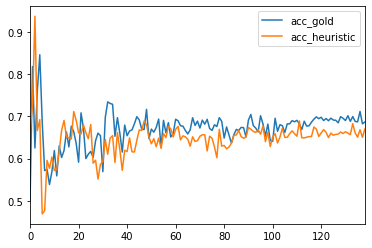

In [40]:
from sklearn.model_selection import train_test_split

data = []
users = df_proc.groupby(['UserID'])
a = np.arange(users.ngroups)
np.random.shuffle(a)
for i in list(range(1,100))+list(range(101,500,10)):
    n = i
#     print("## Testing N={}##".format(n))
    n_respondents = df_proc[users.ngroup().isin(a[:n])]
    # checking to make sure we're getting complete, single sessions
    # some users may have more than one session...
#     n_respondents.groupby('UserID').count().describe()
    X, y = make_X_y(n_respondents)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, stratify=X.index.get_level_values('ExtendedSessionID')
    )
#     y_train.groupby('ExtendedSessionID').count()
    L_train, L_test = labeler.label([X_train, X_test], verbose=False)
    lm = labeler.fit(L_train)
    Labeler.score(lm, L_test, y_test, verbose=False)
    X_train_filtered, probs_train_filtered = labeler.filter_probs(X_train, L_train)
    # baseline gold model accuracy
#     print("Gold accuracy")
    clf.fit(X_train, y_train)
    acc_gold = clf.score(X_test, y_test, verbose=False)
    # label model accuracy
#     print("LF accuracy")
    preds_train_filtered = Labeler.probs_to_preds(probs_train_filtered)
    clf.fit(X_train_filtered, preds_train_filtered)
    acc_lf = clf.score(X_test, y_test, verbose=False)
    data.append((n, acc_gold, acc_lf))
accs = pd.DataFrame(data, columns=["n_voters", "acc_gold", "acc_heuristic"])
accs.to_csv("../figures/data/mm-accs_voters.csv")
accs[['acc_gold', 'acc_heuristic']].plot()

**Performance by training set size**

In [ ]:
clf = Classifier(features, num_features, cat_features)
results = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=11)

for n in list(range(50, 1000, 10))+list(range(1100,10000,100)):
    sample = X.sample(n).index
    X_n = X.loc[sample]
    y_n = y.loc[sample]
    
    gold_acc, lm_acc = kf_cross_val(kf, X_n, y_n)

    # store results
    res = (n, np.mean(gold_acc), np.std(gold_acc), np.mean(lm_acc), np.std(lm_acc))
    print(res)
    results.append(res)
results

50
(50, 0.44000000000000006, 0.12, 0.5599999999999999, 0.1854723699099141)
60
(60, 0.6166666666666666, 0.06666666666666665, 0.6666666666666667, 0.09128709291752769)
70
(70, 0.6142857142857142, 0.13248026422136722, 0.6428571428571429, 0.04517539514526258)
80
(80, 0.675, 0.11456439237389598, 0.7125, 0.05)
90
(90, 0.6888888888888889, 0.09686442096757052, 0.6555555555555556, 0.022222222222222185)
100
(100, 0.58, 0.0678232998312527, 0.6, 0.09486832980505136)
110
(110, 0.6454545454545454, 0.10123207932418224, 0.6181818181818182, 0.09791208740244552)
120
(120, 0.6416666666666668, 0.09718253158075503, 0.6416666666666667, 0.04249182927993987)
130
(130, 0.6538461538461539, 0.11147212881684186, 0.6846153846153846, 0.08904489925223252)
140
(140, 0.6714285714285714, 0.07953949089757174, 0.6214285714285713, 0.11203133672398657)
150
(150, 0.6866666666666666, 0.09333333333333335, 0.5933333333333333, 0.03265986323710904)
160
(160, 0.64375, 0.07551903733496608, 0.61875, 0.045927932677184584)
170
(170, 0

In [ ]:
pd.DataFrame(results, columns=["n_rows", "acc_gold", "std_gold", "acc_heuristic", "std_heuristic"]).to_csv("../figures/data/mm-accs_data.csv")

## Kim et al. Implementation

A replication of the model used by [Kim et al.](https://www.mendeley.com/viewer/?fileId=1b0d79d6-97a3-f7e5-3008-2e14db1a767b&documentId=3f4000f0-5830-358b-a8ea-b031e3ab5403) for estimating voter preferences. Will compare accuracy to Snorkel method.

Here, modeling _utilities_ as $u(\Theta_i) = w^\intercal F(\Theta_i)$, where $\Theta_y$ is the character vector for instance $y$ and $F : \Theta \to \Lambda$ is the mapping from the character vector to an abstract vector. This is accomplished by $F(\Theta) = A\Theta$, where $A$ is a binary matrix denoting the presence of abstract characterisitics.

### Benchmark 1

$u(\Theta) = w^{c\intercal}\Theta$, where $w^c \sim N_k(\mu, \sigma^2I)$.

In [67]:
## TODO: how to estimate w^c?